# MNIST Classifier
Training a basic feedforward neural network to classify handwritten
digits from the MNIST database

In [1]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
plt.style.use('ggplot')

**Load the dataset**

We load the MNIST dataset from torchvision into two separate dataloaders, one for training and
one for testing

In [2]:
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./datasets/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./datasets/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

**Define the Neural Network**

We have opted to use a very simple feedforward neural network with 3 fully connected layers.
Note that the softmax function is not applied to the output. This is because the `torch.nn.CrossEntropyLoss()`
function will internally apply softmax, so applying it here as well would be redundant.

In [3]:
# Create the neural network
class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the tensor
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

**Setup**

Here we setup the neural network model, the loss function, and the optimizer.
 
This network has an input layer which has a size of 784, where each neuron will correspond to a pixel in the image. Then a hidden layer which was arbitrarily chosen to have 196 neurons (784/4), and finally the
output layer which has 10 neurons corresponding to the 10 classes (digits 0-9).

The loss function we use here is the cross entropy loss because it is used with great success for basic image classification techniques. For the
optimizer, we use stochastic gradient descent because it is the most basic/standard optimizer.

In [4]:
input_size = 784 # 28x28 pixel images
hidden_size = 196 # 1/4 the input size (picked arbitrarily)
num_classes = 10 # 10 classes (digits 0 - 9)
model = NeuralNet(input_size, hidden_size, num_classes)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

**Training**

Here we train the model and plot the loss history as usually

*Note:* to retrain the model, delete or rename the saved model in the models/ directory.

In [5]:
model_file_path = "./models/mnist_model.pt"
if not os.path.isfile(model_file_path):

    loss_hist = []
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        model.train()
        optimizer.zero_grad()

        # Do a forward pass to get a prediction from the model
        pred = model(data)

        # Compute the loss
        loss = criterion(pred, target)
        loss_hist.append(loss.item())

        # Compute gradients and take a gradient step
        loss.backward()
        optimizer.step()

    # plot the loss history
    fig, ax = plt.subplots(figsize=(5,3));
    ax.plot(loss_hist, color="blue");
    ax.set(title="Loss history");
else:
    print(f"Loading model: {model_file_path}")
    model.load_state_dict(torch.load(model_file_path))
    model.eval()

Loading model: ./models/mnist_model.pt


In [6]:
# Run this to save the trained model:
if not os.path.isfile(model_file_path):
    print(f"Saved trained model to {model_file_path}]")
    torch.save(model.state_dict(), "./models/mnist_model.pt")
else:
    print("Model file already exists. Delete/rename old file before saving a new one")


Model file already exists. Delete/rename old file before saving a new one


**Testing**

To compute the accuracy of the model, we compare the outputs of the model on the test data with the associated labels

In [7]:
hits = 0
misses = 0
with torch.no_grad():
    for data, labels in test_loader:

        # Pass each batch of data through the model and softmax
        output = model(data)
        output = F.softmax(output, dim=1) # map values to be between 0 and 1

        # The index of the largest value is the predicted class
        pred_class = torch.tensor([torch.argmax(outs) for outs in output])

        # Compare the predicted classes to the true labels and tally up hits and misses
        comp = (labels == pred_class)
        for i in range(len(comp)):
            if comp[i]:
                hits += 1
            else:
                misses += 1

    # Print the results
    print(f"Hits = {hits}")
    print(f"Misses = {misses}")
    print(f"Accuracy = {100*hits/(hits+misses)} %")

Hits = 9141
Misses = 859
Accuracy = 91.41 %


Running the cell below will get a test image, display it,
run it through the model, then show a bar graph displaying the confidence percentages for each class (digit)

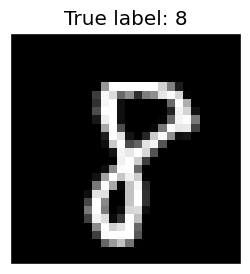

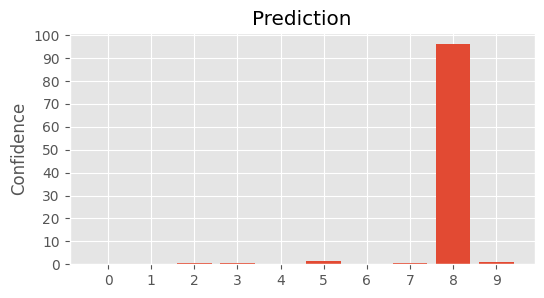

In [17]:
test_data = enumerate(test_loader)
batch_idx, (test_data, test_labels) = next(test_data)
test_img = test_data[0]

# Show the image
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(test_img.squeeze(), cmap='gray')
ax.set(title=f"True label: {test_labels[0]}")
ax.set_xticks([])
ax.set_yticks([])

# Run the image through the model
res = model(test_img).detach()
res = F.softmax(res, dim=1).numpy().flatten()
res_dict = {i : 100*res[i] for i in range(len(res))}

# Bar graph of the predicted class
fig, ax = plt.subplots(figsize=(6,3))
ax.bar(res_dict.keys(), res_dict.values())
ax.set(title="Prediction", ylabel="Confidence")
ax.set_xticks(np.arange(0,10,1));
ax.set_yticks(np.arange(0,110,10));